# GANs_2D

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using "T4 GPU".

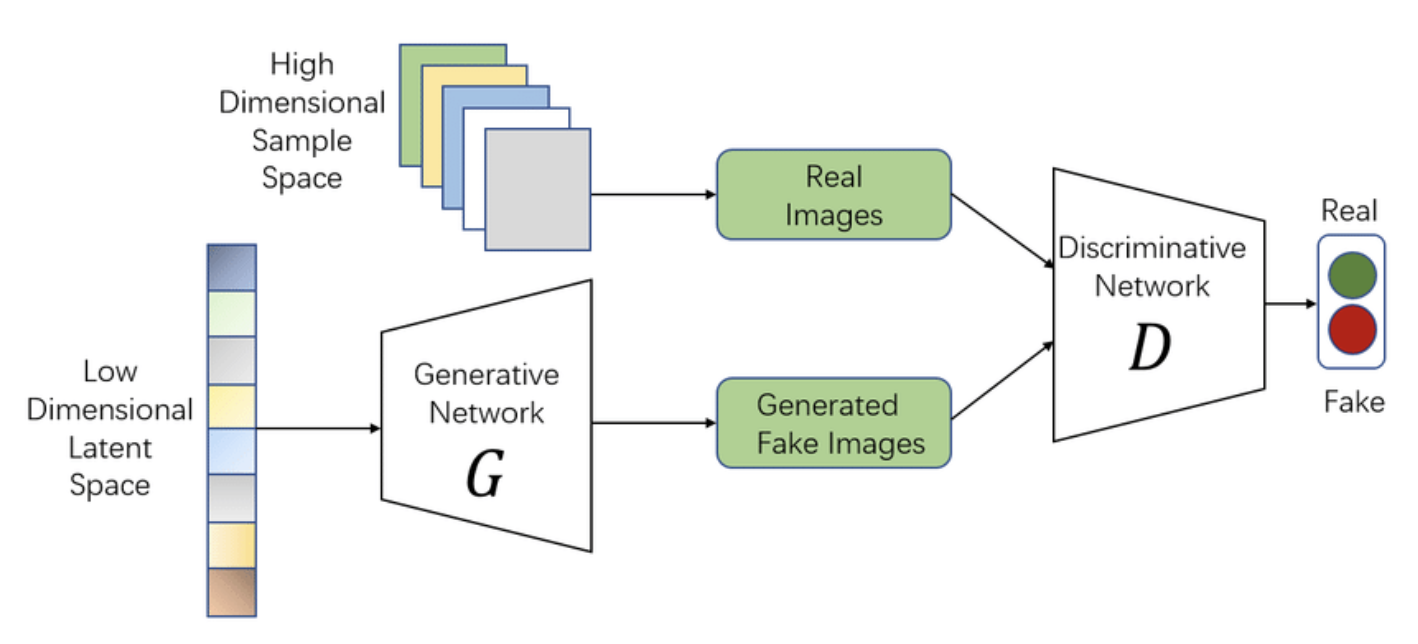

In [1]:
import time

In [2]:
def print_time_execution(start, end, txt):

  delta = int(end - start)

  hours = int(delta/3_600)
  mins = int((delta - 3_600*hours)/60)
  segs = int(delta - hours*3600 - mins*60)

  return f'{txt} it takes {hours} hours, {mins} mins and {segs} segs.'

### Start time of execution

In [3]:
start = time.time()

# 1. Import Libraries

In [4]:
import numpy as np
from numpy import ones
from numpy import zeros
from numpy import hstack
from numpy import vstack
from numpy import expand_dims
from numpy.random import randn
from keras.layers import Dense
from keras.layers import Conv2D
import matplotlib.pyplot as plt
from numpy.random import randint
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.layers import Conv2DTranspose
from keras.datasets.mnist import load_data

# 2. Import Data

In [5]:
(trainX, trainy), (testX, testy) = load_data()

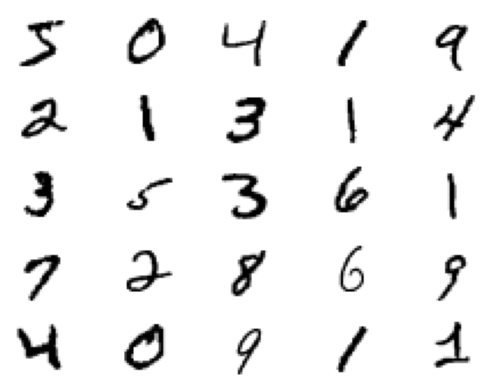

In [6]:
for i in range(25):

  plt.subplot(5, 5, 1 + i)
  plt.axis('off')
  plt.imshow(trainX[i], cmap = 'gray_r')

plt.show()

# 3. Discriminator and Generator

In [7]:
def define_discriminator(in_shape=(28,28,1)):

  model = Sequential()

  model.add(Conv2D(64, (3,3), strides = (2, 2), padding = 'same', input_shape = in_shape))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.4))
  model.add(Conv2D(64, (3,3), strides = (2, 2), padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.4))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)

  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

  return model

In [8]:
def define_generator(latent_dim):

  model = Sequential()
  # foundation for 7x7 image
  n_nodes = 128 * 7 * 7

  model.add(Dense(n_nodes, input_dim = latent_dim))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Reshape((7, 7, 128)))

  # upsample to 14x14
  model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))

  # upsample to 28x28
  model.add(Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same'))
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Conv2D(1, (7,7), activation = 'sigmoid', padding = 'same'))

  return model

In [9]:
def define_gan(g_model, d_model):

  d_model.trainable = False

  # connect them
  model = Sequential()

  # add generator
  model.add(g_model)

  # add the discriminator
  model.add(d_model)

  # compile model
  opt = Adam(learning_rate = 0.0002, beta_1 = 0.5)

  model.compile(loss = 'binary_crossentropy', optimizer = opt)

  return model

In [10]:
def load_real_samples():

  # load mnist dataset
   (trainX, _), (_, _) = load_data()

   # expand to 3d, e.g. add channels dimension
   X = expand_dims(trainX, axis = -1)

   # convert from unsigned ints to floats
   X = X.astype('float32')

   # scale from [0,255] to [0,1]
   X = X / 255.0

   return X

In [11]:
def generate_real_samples(dataset, n_samples):

  # choose random instances
  ix = randint(0, dataset.shape[0], n_samples)

  # retrieve selected images
  X = dataset[ix]

  # generate 'real' class labels (1)
  y = ones((n_samples, 1))

  return X, y

In [12]:
def generate_latent_points(latent_dim, n_samples):

  # generate points in the latent space
  x_input = randn(latent_dim * n_samples)

  # reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)

  return x_input

In [13]:
def generate_fake_samples(g_model, latent_dim, n_samples):

  # generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)

  # predict outputs
  X = g_model.predict(x_input)

  # create 'fake' class labels (0)
  y = zeros((n_samples, 1))

  return X, y

In [14]:
def save_plot(examples, epoch, n = 10):
  # plot images
  for i in range(n * n):

    # define subplot
    plt.subplot(n, n, 1 + i)

    # turn off axis
    plt.axis('off')

    # plot raw pixel data
    plt.imshow(examples[i, :, :, 0], cmap = 'gray_r')

In [15]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples = 100):

  # prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)

  # evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

  # prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

  # evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

  # summarize discriminator performance
  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

  # save plot
  save_plot(x_fake, epoch)

# 4. Train

In [16]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs = 100, n_batch = 256):

  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)

  # manually enumerate epochs
  for i in range(n_epochs):
    print(i)
    # enumerate batches over the training set
    for j in range(bat_per_epo):
      # get randomly selected 'real' samples
      X_real, y_real = generate_real_samples(dataset, half_batch)

      # generate 'fake' examples
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

      # create training set for the discriminator
      X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

      # update discriminator model weights
      d_loss, _ = d_model.train_on_batch(X, y)

      # prepare points in latent space as input for the generator
      X_gan = generate_latent_points(latent_dim, n_batch)

      # create inverted labels for the fake samples
      y_gan = ones((n_batch, 1))

      # update the generator via the discriminator's error
      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      # summarize loss on this batch
      print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

    # evaluate the model performance, sometimes
    if (i+1) % 5 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
>190, 83/234, d=0.693, g=0.692
4/4 [==============================] - 0s 3ms/step
>190, 84/234, d=0.690, g=0.687
4/4 [==============================] - 0s 3ms/step
>190, 85/234, d=0.691, g=0.697
4/4 [==============================] - 0s 3ms/step
>190, 86/234, d=0.696, g=0.697
4/4 [==============================] - 0s 4ms/step
>190, 87/234, d=0.693, g=0.690
4/4 [==============================] - 0s 4ms/step
>190, 88/234, d=0.695, g=0.694
4/4 [==============================] - 0s 3ms/step
>190, 89/234, d=0.692, g=0.693
4/4 [==============================] - 0s 3ms/step
>190, 90/234, d=0.693, g=0.691
4/4 [==============================] - 0s 3ms/step
>190, 91/234, d=0.692, g=0.691
4/4 [==============================] - 0s 3ms/step
>190, 92/234, d=0.692, g=0.697
4/4 [==============================] - 0s 3ms/step
>190, 93/234, d=0.695, g=0.692
4/4 [==============================] - 0s 3ms/step
>190, 94/234, d=0.690, g=0.701


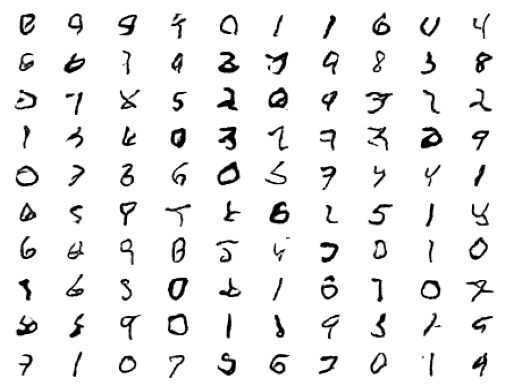

In [17]:
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# load image data
dataset = load_real_samples()

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, 200)

# 5. Generation

In [18]:
x_gen, _ = generate_fake_samples(g_model, latent_dim, 20)

1/1 [==============================] - 0s 248ms/step


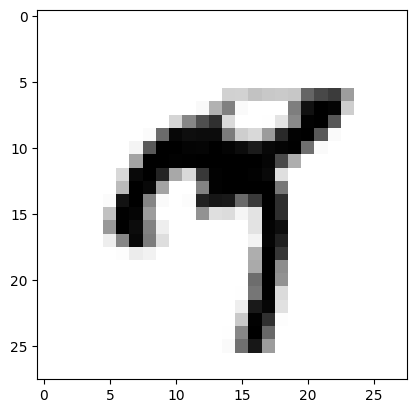

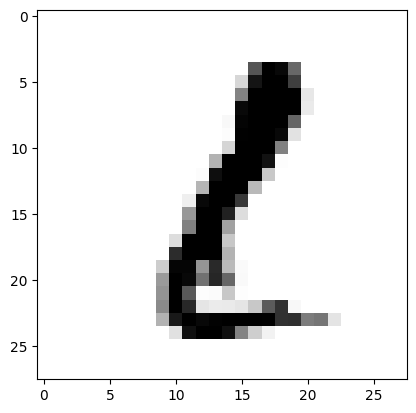

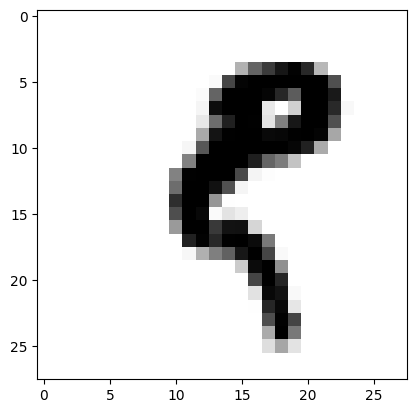

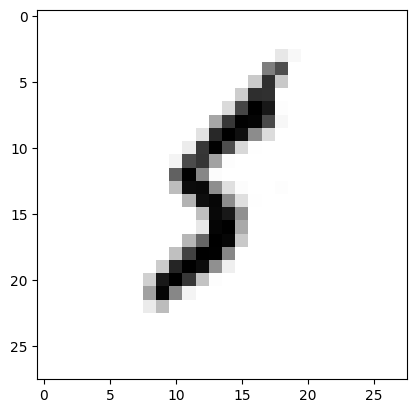

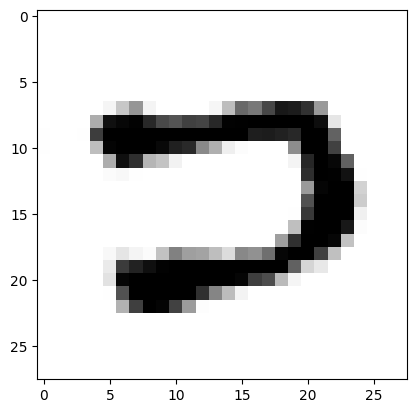

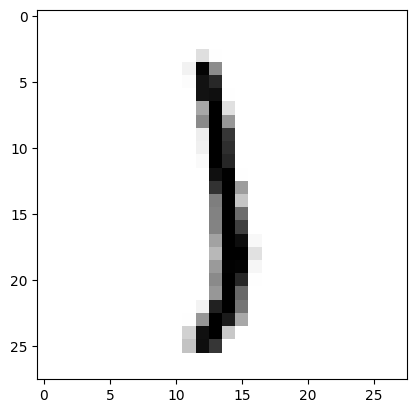

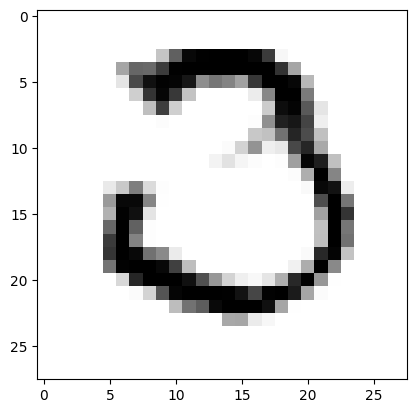

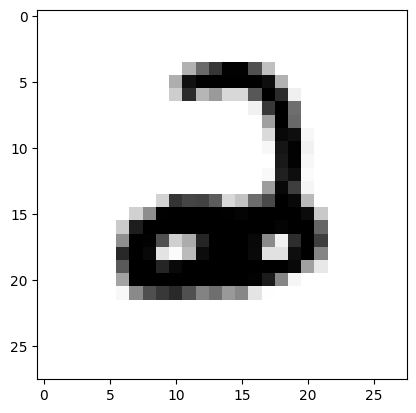

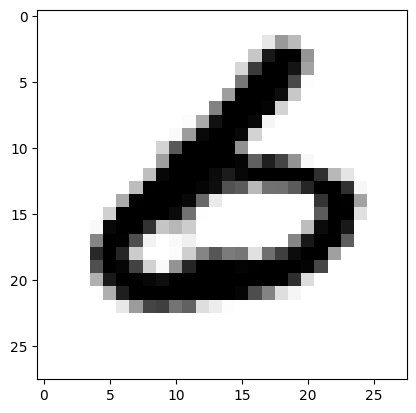

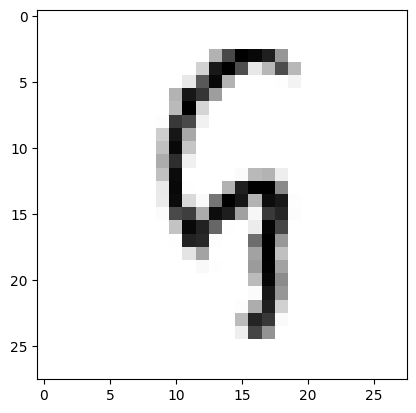

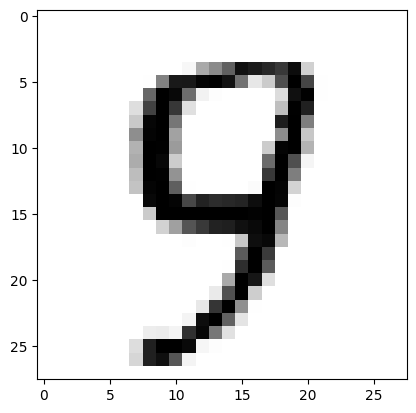

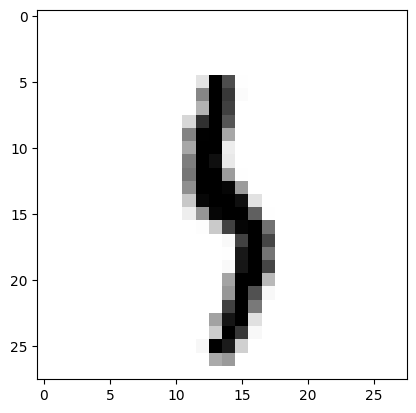

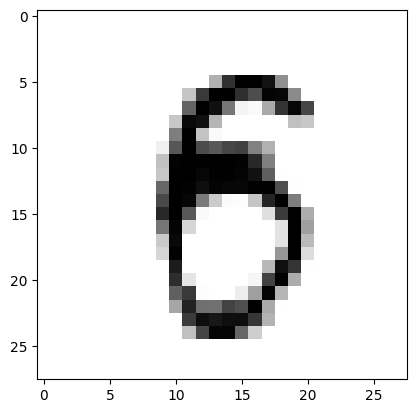

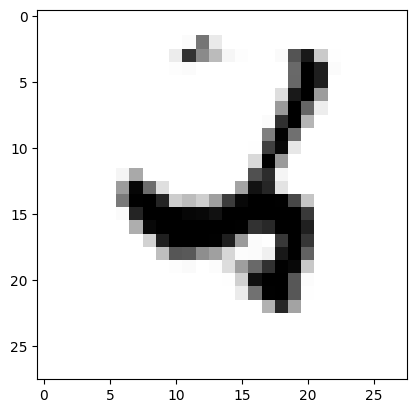

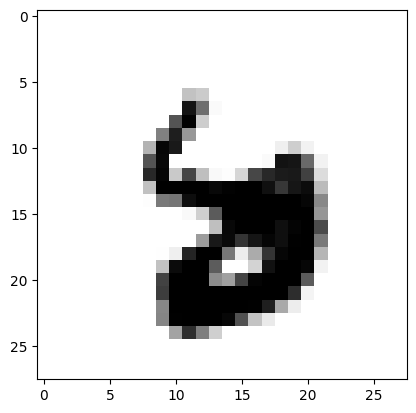

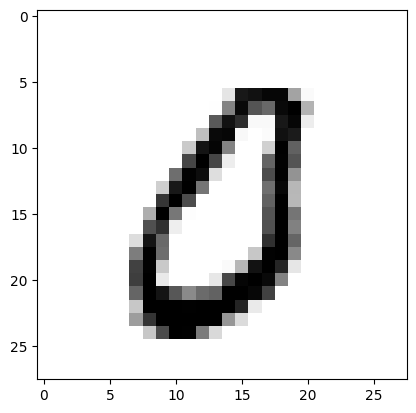

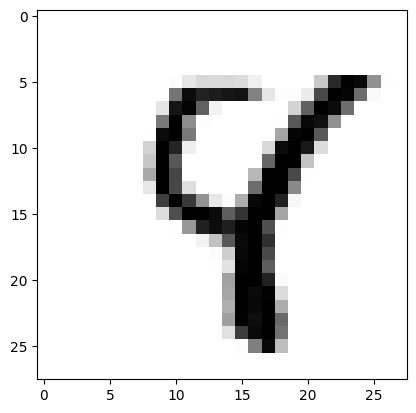

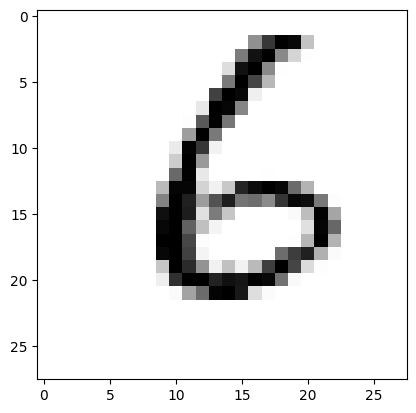

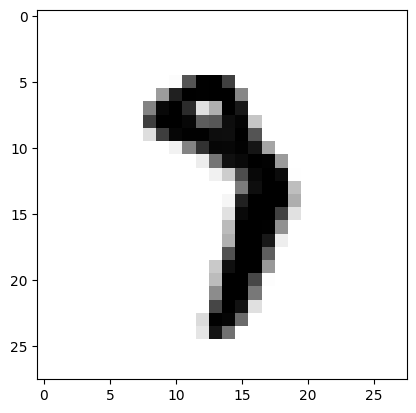

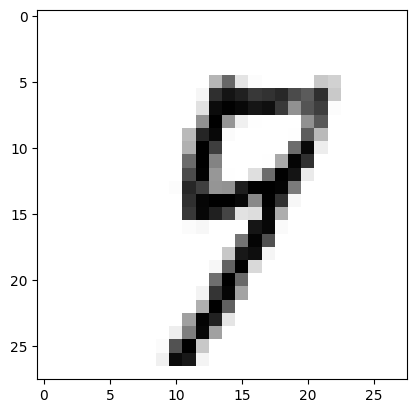

In [19]:
for i in range(20):
  plt.imshow(x_gen[i], cmap = 'gray_r')
  plt.show()

### End time of execution

In [20]:
end = time.time()

In [21]:
print(print_time_execution(start, end, 'this notebook'))

this notebook it takes 2 hours, 23 mins and 58 segs.
